In [1]:
from __future__ import print_function

import logging
import sys
root_logger = logging.getLogger()
stdout_handler = logging.StreamHandler(sys.stdout)
root_logger.addHandler(stdout_handler)
root_logger.setLevel(logging.DEBUG)

import mxnet as mx
from mxnet import nd, autograd, sym, mod
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from src.fetch_mnist import preprocessed_mnist
from sklearn.model_selection import train_test_split

# Convolutional NN - Autoencoder

In this notebook we set up an autoencoder that uses convolutional instead of fully connected hidden layers.

### Why convolutions?

**Drawbacks of using fully connected layers on image input** 

* FC layers don't exploit local structure
* FC layer is not equivariant under translation (translated pattern can correspond to completely different feature)
* For big images FC layers have huge number of parameters (for example for 1000 hidden units, 1000 x 1000 x 3 image such layer has ~3 billion weights)

**CNN layers:**

* Extract local features
* Are equivariant to translation
* Have lot less parameters, since they share kernel over the whole input image 


## Contents:

* [Network definition](#model_definition)

* [Fitting and visualization](#fitting_visualization)

### Data setup

Note we have to reshape data to make 2d convolution possible

In [ ]:
X_train, X_test, y_train, y_test = preprocessed_mnist(random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5) 
category_count = len(np.unique(y_train))

def data_iter(X, y, batch_size=256):
  batch_size = min(X.shape[0], batch_size)
  return mx.io.NDArrayIter(
    data=nd.array(X),
    label=nd.array(X),
    batch_size=batch_size,
    label_name='data')

def plot_two_img_rows(X1, X2, title, j=5, do_reshape=True):
  f, axes = plt.subplots(2, j, figsize=(20, 40 / j))
  f.suptitle(title)
  for k, x in zip(range(2), [X1, X2]):
    for i in range(j):
      ax = axes[k, i]
      img = x[i]
      if do_reshape:
        img = img[i, :].reshape(28, 28)
      ax.imshow(img, cmap='gray')
      ax.axis('off')
  plt.show()

train_iter = data_iter(X_train, y_train)
valid_iter = data_iter(X_valid, y_valid)
test_iter = data_iter(X_test, y_test)


# reshaping data 

X_train_len = X_train.shape[0]
X_valid_len = X_valid.shape[0]
X_test_len = X_test.shape[0]
X_shape = (28, 28)

train_iter2d = data_iter(X_train.reshape(X_train_len, 1, *X_shape), y_train)
valid_iter2d = data_iter(X_valid.reshape(X_valid_len, 1, *X_shape), y_valid)
test_iter2d = data_iter(X_test.reshape(X_test_len, 1, *X_shape), y_test)

In [4]:
input_size = 784
hidden_size = 20 

training_param_args = {
  'num_epoch': 10,
  'eval_metric': 'rmse',
  'optimizer_params':{'learning_rate': 0.33}
}

<a id='model_definition'></a>

In [5]:
def conv_autoencoder_loss(input_size, hidden_size, num_filter, kernel):
  data = sym.Variable('data')
  weights = sym.Variable(name='weights', 
                         shape=(hidden_size, num_filter, *kernel),
                         init=mx.init.Xavier())
  bias_out = sym.Variable(name='bias_out', shape=(1, 1, *input_size), init=mx.init.Zero())
  
  hid_in = sym.Convolution(
    data=data,
    weight=weights,
    num_filter=hidden_size,
    kernel=kernel,
    name='hidden_in')
  
  codes = sym.Activation(hid_in, act_type='relu', name='codes')
  hid_out = sym.Deconvolution(
    codes,
    weights,
    num_filter=num_filter,
    kernel=kernel,
    name='hidden_out')
  
  out = sym.broadcast_add(
    sym.Activation(hid_out, act_type='relu', name='out'),
    bias_out
  )
  return mx.symbol.MakeLoss(
    mx.symbol.LinearRegressionOutput(data=out, label=data)
  )

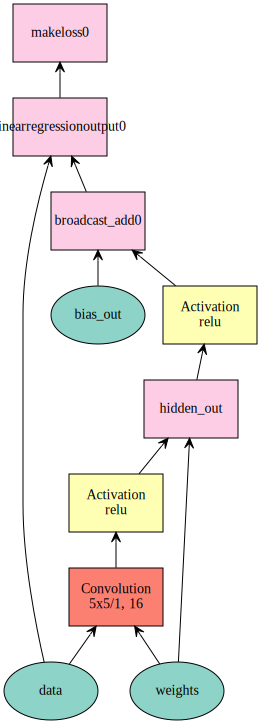

In [6]:
conv_autoencoder = mod.Module(
  symbol=conv_autoencoder_loss(
    input_size=(28, 28),
    hidden_size=16,
    num_filter=1,
    kernel=(5,5)),
  label_names=['data'])

mx.viz.plot_network(conv_autoencoder.symbol)

<a id='fitting_visualization'></a>

In [8]:
%time conv_autoencoder.fit(train_iter2d, eval_data=valid_iter2d, **training_param_args)
conv_reconstructed_digits = conv_autoencoder.predict(valid_iter2d)

Epoch[0] Train-rmse=0.495298
Epoch[0] Time cost=51.320
Epoch[0] Validation-rmse=0.532807
Epoch[1] Train-rmse=0.439459
Epoch[1] Time cost=57.498
Epoch[1] Validation-rmse=0.488243
Epoch[2] Train-rmse=0.422104
Epoch[2] Time cost=51.994
Epoch[2] Validation-rmse=0.417472
Epoch[3] Train-rmse=0.410638
Epoch[3] Time cost=50.911
Epoch[3] Validation-rmse=0.429151
Epoch[4] Train-rmse=0.398010
Epoch[4] Time cost=50.038
Epoch[4] Validation-rmse=0.439918
Epoch[5] Train-rmse=0.389970
Epoch[5] Time cost=50.731
Epoch[5] Validation-rmse=0.443593
Epoch[6] Train-rmse=0.383099
Epoch[6] Time cost=51.983
Epoch[6] Validation-rmse=0.450746
Epoch[7] Train-rmse=0.377515
Epoch[7] Time cost=50.365
Epoch[7] Validation-rmse=0.442432
Epoch[8] Train-rmse=0.372306
Epoch[8] Time cost=50.238
Epoch[8] Validation-rmse=0.399466
Epoch[9] Train-rmse=0.362201
Epoch[9] Time cost=65.128
Epoch[9] Validation-rmse=0.358966
CPU times: user 18min 26s, sys: 12.3 s, total: 18min 38s
Wall time: 9min 23s


[('rmse', 0.32757400934185299)]


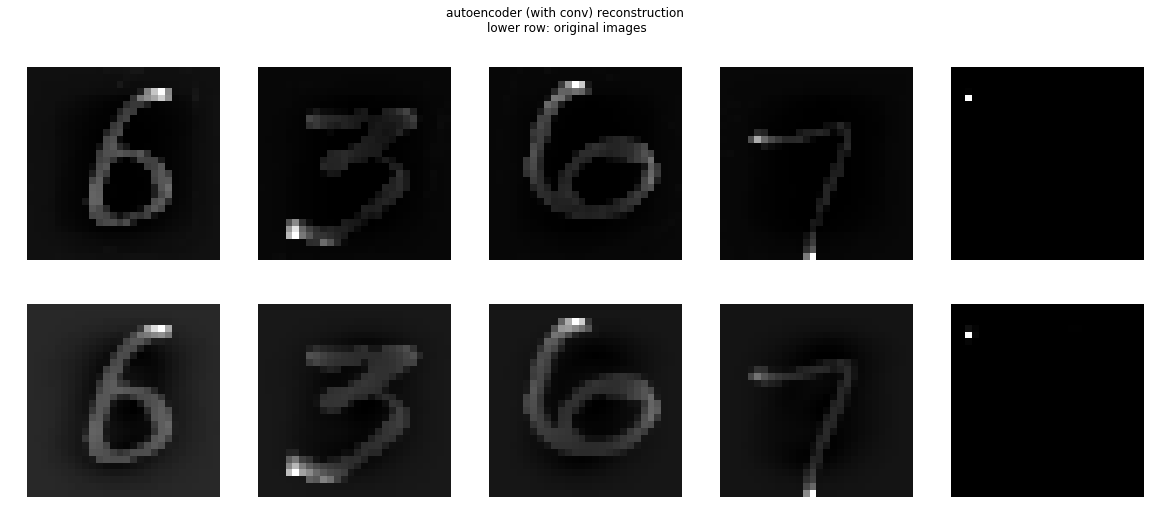

In [14]:
print(conv_autoencoder.score(test_iter2d, eval_metric='rmse'))

conv_reconstructed_digit_examples = conv_reconstructed_digits[:10].asnumpy()

plot_two_img_rows(conv_reconstructed_digit_examples[:10].reshape(10, 28, 28), X_valid[:10].reshape(10,28,28), 'autoencoder (with conv) reconstruction \nlower row: original images', do_reshape=False)